[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pabanib/Cursos/blob/master/Espacial/3_espacial.ipynb)

 # **<font color="lightblue">Manipulación de datos espaciales</font>**



<p align="justify">
En el colab anterior aprendimos ha realizar mapas que nos pueden serivir para obtener información geográfica con la visualización. Pero, aún no hemos aprendido a manipular completamente los datos geográficos que vienen en un conjunto de datos.
<br><br>
Esta tarea es la que vamos a trabajar en el presente colab, de esta forma podemos mejorar el potencial para encontrar patrones espaciales en nuestros datos.


 ## **<font color="lightblue">Instalación y carga de bibliotecas</font>**

In [1]:
import setup

La biblioteca folium se ha instalado correctamente.
La biblioteca mapclassify se ha instalado correctamente.
La biblioteca geodatasets se ha instalado correctamente.
La biblioteca pysal se ha instalado correctamente.
Todas las bibliotecas se han instalado o se han intentado instalar.


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests # Para descargar archivos de internet
import zipfile  # Para descomprimir archivos zip
import os
dir_actual = os.getcwd()

c:\Anaconda3\envs\espacial\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.0-CAPI-1.17.0). Conversions between both will be slow.
  warnings.warn(
C:\Users\Pablo\AppData\Local\Temp\ipykernel_23700\4065867215.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/e

👀 Descargamos el archivo .csv

In [4]:
url = "https://github.com/pabanib/dataframes/raw/master/airbnb/caba_airbnb.csv"
nombre_archivo = "caba_airbnb.csv" # Nombre del archivo local para guardar los datos descargados

try:
    # Realizar la solicitud HTTP para descargar el archivo
    respuesta = requests.get(url)

    # Verificar si la descarga fue exitosa (código de respuesta 200)
    if respuesta.status_code == 200:
        # Guardar el contenido descargado en un archivo local
        with open(nombre_archivo, "wb") as archivo:
            archivo.write(respuesta.content)
        print("Archivo descargado exitosamente como:", nombre_archivo)
    else:
        print("Error al descargar el archivo. Código de respuesta:", respuesta.status_code)
except requests.RequestException as e:
    print("Error durante la solicitud HTTP:", e)

Archivo descargado exitosamente como: caba_airbnb.csv


👀 Descargamos los archivos .zip y los descomprimimos en el entorno de colab para luego leerlos

In [5]:
# URL de los archivos ZIP que deseas descargar (enlaces raw)
url1 = "https://github.com/pabanib/dataframes/raw/master/censo/caba_dptos.zip"
url2 = "https://github.com/pabanib/dataframes/raw/master/censo/radios_caba.zip"

# Descargar y descomprimir el primer archivo ZIP
try:
    respuesta1 = requests.get(url1, stream=True)
    respuesta1.raise_for_status()
    with open("caba_dptos.zip", "wb") as archivo_zip1:
        for chunk in respuesta1.iter_content(chunk_size=8192):
            archivo_zip1.write(chunk)
    with zipfile.ZipFile("caba_dptos.zip", 'r') as zip_ref:
        zip_ref.extractall(dir_actual)                                         
    print("Archivo ZIP 1 descomprimido correctamente.")
except requests.exceptions.RequestException as e:
    print("Error al descargar o descomprimir el archivo ZIP 1:", e)

# Descargar y descomprimir el segundo archivo ZIP
try:
    respuesta2 = requests.get(url2, stream=True)
    respuesta2.raise_for_status()
    with open("radios_caba.zip", "wb") as archivo_zip2:
        for chunk in respuesta2.iter_content(chunk_size=8192):
            archivo_zip2.write(chunk)
    with zipfile.ZipFile("radios_caba.zip", 'r') as zip_ref:
        zip_ref.extractall(dir_actual)                                         
    print("Archivo ZIP 2 descomprimido correctamente.")
except requests.exceptions.RequestException as e:
    print("Error al descargar o descomprimir el archivo ZIP 2:", e)


Archivo ZIP 1 descomprimido correctamente.
Archivo ZIP 2 descomprimido correctamente.


 ## **<font color="lightblue">De DataFrame a GeoDataFrame</font>**

<p align="justify">
Podemos encontrarnos el caso en que nuestro conjunto de datos este en formato .csv y no en los formatos espaciales que vimos anteriormente. Este caso por lo general va suceder en datos que sean un conjunto de puntos en el espacio ya que sería muy difícil guardar polígonos en un archivo plano. En efecto, vamos a necesitar transformarlo en un GeoDataFrame para obtener la información espacial.
<br><br>
👀 Este caso se va a dar en el archivo de Airbnb para la ciudad de Buenos Aires con el cual vamos a trabajar.

In [6]:
df = pd.read_csv("caba_airbnb.csv")
df.head()

latitude  longitude  bathrooms    bathrooms_text  bedrooms  beds  \
0 -34.57896  -58.43448        NaN            1 bath       1.0   1.0   
1 -34.60728  -58.41949        NaN  1.5 shared baths       1.0   1.0   
2 -34.59495  -58.40440        NaN            1 bath       1.0   1.0   
3 -34.57943  -58.48487        NaN           2 baths       1.0   2.0   
4 -34.59234  -58.39956        NaN            1 bath       1.0   1.0   

        price  minimum_nights  maximum_nights  minimum_minimum_nights  ...  \
0  $10,401.00               7              90                       7  ...   
1   $2,692.00               3           10000                       3  ...   
2  $13,522.00               5             180                       5  ...   
3   $9,318.00               1            1125                       1  ...   
4   $9,465.00              14            1125                      14  ...   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         5.00                    5.00                 4.56   
1                         4.82                    4.61                 4.71   
2                         4.96                    4.75                 4.78   
3                         4.50                    4.50                 5.00   
4                         4.95                    4.90                 4.40   

   license  instant_bookable  calculated_host_listings_count  \
0      NaN                 f                               1   
1      NaN                 f                               2   
2      NaN                 f                              24   
3      NaN                 f                               2   
4      NaN                 f                              30   

  calculated_host_listings_count_entire_homes  \
0                                           1   
1                                           0   
2                                          24   
3                                           0   
4                                          29   

   calculated_host_listings_count_private_rooms  \
0                                             0   
1                                             2   
2                                             0   
3                                             2   
4                                             0   

   calculated_host_listings_count_shared_rooms  reviews_per_month  
0                                            0               0.06  
1                                            0               0.29  
2                                            0               0.89  
3                                            0               0.03  
4                                            0               0.19  

[5 rows x 41 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22713 entries, 0 to 22712
Data columns (total 41 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   latitude                                      22713 non-null  float64
 1   longitude                                     22713 non-null  float64
 2   bathrooms                                     0 non-null      float64
 3   bathrooms_text                                22688 non-null  object 
 4   bedrooms                                      19655 non-null  float64
 5   beds                                          22481 non-null  float64
 6   price                                         22713 non-null  object 
 7   minimum_nights                                22713 non-null  int64  
 8   maximum_nights                                22713 non-null  int64  
 9   minimum_minimum_nights                        22713 non-null 

<p align="justify">
🛑 Airbnb ofrece los datos de varias ciudades del mundo disponible para descargar y trabajarlos en el siguiente enlace: <a href="http://insideairbnb.com/get-the-data/">http://insideairbnb.com/get-the-data/</a>.
<br><br>
El dataset contiene una amplia cantidad de características que tienen los deparatamentos que están en alquiler. En este colab nos sentraremos principalmente en el precio y obvio también en el dato geográfico que viene establecido como un punto en el espacio con la latitud y longitud.
<br><br>
Los datos son actualizado constantemente siendo estos actualizados en marzo del presente año. El primer inconveniente que encontramos es que el precio no se encuentra establecido como un dato numérico. Por lo tanto vamos a convertirlo.

In [8]:
def conv_numero(tex):
    t = tex.replace('$','').replace(',','')
    return float(t)

df.price = df.price.apply(conv_numero)

In [9]:
df.describe()['price']

count    2.271300e+04
mean     1.546744e+04
std      1.484434e+05
min      1.750000e+02
25%      6.388000e+03
50%      8.969000e+03
75%      1.346000e+04
max      2.050043e+07
Name: price, dtype: float64

<p align="justify">
Como sabemos, lo que separa a un dataframe de pandas de un geodataframe es solo la geoserie que contiene el segundo que es un conjunto de datos geométricos. Entonces, para convertir el dataframe necesitamos decirle a geopandas que los valores que tenemos en latitud y longitud representan a un punto en el espacio.
<br><br>
La función para resolver este punto es <code>gpd.points_from_xy()</code>, pide como argumentos el eje x (longitud) y el eje y (latitud).

In [10]:
geo = gpd.points_from_xy(x = df.longitude,y =  df.latitude)
gdf = gpd.GeoDataFrame(df[['price','bedrooms','minimum_nights','maximum_nights']], geometry= geo)
gdf.head()

price  bedrooms  minimum_nights  maximum_nights  \
0  10401.0       1.0               7              90   
1   2692.0       1.0               3           10000   
2  13522.0       1.0               5             180   
3   9318.0       1.0               1            1125   
4   9465.0       1.0              14            1125   

                      geometry  
0  POINT (-58.43448 -34.57896)  
1  POINT (-58.41949 -34.60728)  
2  POINT (-58.40440 -34.59495)  
3  POINT (-58.48487 -34.57943)  
4  POINT (-58.39956 -34.59234)

<p align="justify">
El gdf así construido ahora reperesenta a un conjunto de puntos en el espacio. Pero, para referenciarlo geográficamente es necesario agregarle una proyección. En este caso, las proyecciones que habitualmente se informan en estos tipos de datos es la "WGS 84"

In [11]:
gdf.crs

In [12]:
gdf.crs = "WGS 84"
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

 ## **<font color="lightblue">Combinando datos de diferentes datasets</font>**

<p align="justify">
👀 Frecuentemente la información que necesitamos para trabajar no esta completa en un solo archivo, por lo tanto necesitamos combinarlos. En una base de datos común vamos a necesitar emparejar algún valor unívoco. La ventaja que nos ofrece el dato georeferenciado es que esa combinación se encuentra a través de la referencia espacial.
<br><br>
En este caso podemos juntar los datos que nos proporciona Airbnb con los provenientes del censo Nacional 2022 que ya estuvimos analizando. De esta forma podemos darle un contexto geográfico más amplio a los alquileres temporales.


In [13]:
# Leemos los datos del censo, en este caso el que define las comunas dentro de CABA y los radios censales
caba = gpd.read_file("caba_dptos.shp")
radios = gpd.read_file("radios_caba.shp")
caba.head()

id  old_id          area  perimeter prov depto   nomdepto   link   ind01  \
0  432       1  6.850621e+06  10990.640   02   042   Comuna 6  02042  109241   
1  428       1  2.237446e+07  20962.866   02   056   Comuna 8  02056   68430   
2  429       1  2.268917e+07  29116.702   02   028   Comuna 4  02028  103918   
3  434       1  1.562627e+07  17247.637   02   084  Comuna 12  02084  120316   
4  430       1  1.242216e+07  17971.723   02   049   Comuna 7  02049  105610   

   ind03  ... ind08 ind09 ind10 ind11 ind12 ind13 ind14 ind15  \
0   99.9  ...   0.0   0.0   1.2   0.2   0.0   0.1   0.2   0.0   
1  100.0  ...   0.0  26.5   0.9   0.2   0.0   0.2   0.2   0.0   
2   99.9  ...   0.0  14.5   6.4   0.2   0.0   0.3   0.3   0.0   
3   99.9  ...   0.0   0.0   0.4   0.4   0.0   0.1   0.2   0.0   
4   99.9  ...   0.0   5.7   2.8   0.2   0.0   0.1   0.2   0.0   

                           nomprov  \
0  Ciudad Autónoma de Buenos Aires   
1  Ciudad Autónoma de Buenos Aires   
2  Ciudad Autónoma de Buenos Aires   
3  Ciudad Autónoma de Buenos Aires   
4  Ciudad Autónoma de Buenos Aires   

                                            geometry  
0  POLYGON ((-58.43230 -34.60395, -58.43150 -34.6...  
1  POLYGON ((-58.44910 -34.65118, -58.44879 -34.6...  
2  POLYGON ((-58.35517 -34.61945, -58.35511 -34.6...  
3  POLYGON ((-58.48211 -34.58098, -58.48298 -34.5...  
4  POLYGON ((-58.45900 -34.61475, -58.45846 -34.6...  

[5 rows x 24 columns]

In [14]:
# Proyetamos todos los gdf con el crs para Argentina epsg = 22177
gdf = gdf.to_crs(epsg = 22177)
caba = caba.to_crs(epsg = 22177)
radios = radios.to_crs(epsg = 22177)

gdf.crs == caba.crs, gdf.crs == radios.crs

(True, True)

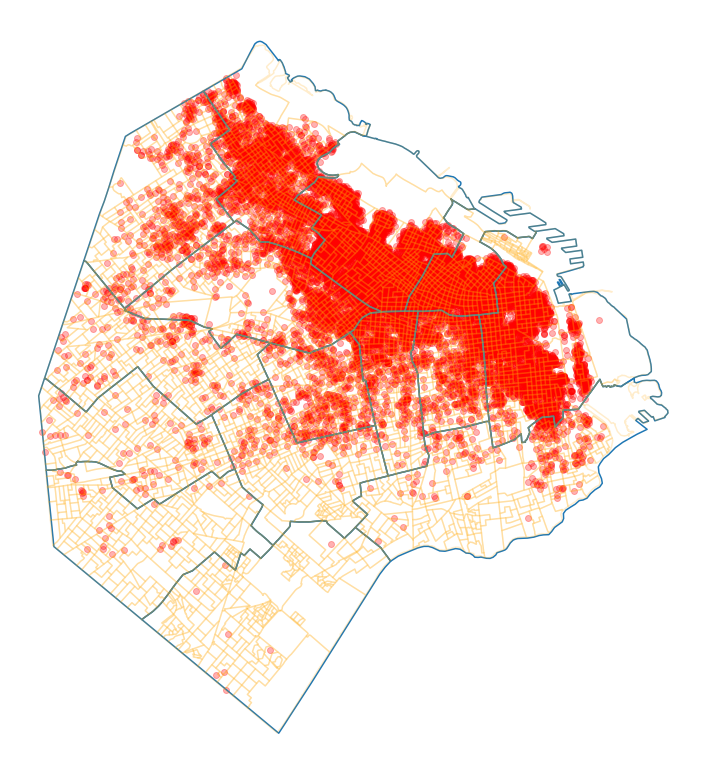

In [15]:
base = caba.boundary.plot(figsize = (16,14)) # definimos el mapa base con los límites de las comunas
radios.boundary.plot(ax = base, color = 'orange', alpha = 0.2) # Este define los límites de los radios censales
gdf.plot(ax = base, color = 'red', alpha = 0.3) # Muestra los departamentos en alquiler
base.set_axis_off()

<p align="justify">
Evidentemente la distribución de los alquileres no es aleatoria en el espacio. Hay sectores que concentran una gran cantidad de departamentos en alquiler temporario. Este hecho, es un supuesto de partida en lo que es la estadística espacial que veremos más adelante.
<br><br>
Utilicemos <code>folium</code> para observar algunos puntos.
<br><br>
Folium utiliza en su confección de mapas la proyección wgs 84 por lo que es necesario proyectar los puntos hacia ella.

In [16]:
gdf_wgs84 = gdf.to_crs(epsg = 4326)

In [17]:
import folium

#Queremos marcar en el mapa los departamentos más caros

#Elijo los 5 valores más altos
valores =  gdf_wgs84.price.sort_values(ascending = True).iloc[-5:].values
filtro = gdf_wgs84.price.apply(lambda x: x in valores)
puntos = gdf_wgs84[filtro]

# Creo el mapa con explore() y le agrego cada uno de los puntos deseados
m = caba.boundary.explore()
for k, r in puntos.iterrows():
  popup_text = f"Precio: {r['price']} Habitaciones: {r['bedrooms']}" # genereno la descripción de lo que voy a mostrar y el precio de la vivienda
  popup = folium.Popup(popup_text, show = False) #genero un objeto de tipo folium.Popup
  m.add_child(folium.Marker([r.geometry.y,r.geometry.x],popup=popup)) #folium pide que primero se le pase la latitud y luego la longitud

m

In [18]:
popup.show

False

<p align="justify">
Si queremos ver todos los puntos, se pone más complicado por la gran cantidad que existen. Existen herramientas que nos permiten ir agrupando puntos de acuerdo a la cercanía en pequeños clusters.

In [19]:
from folium.plugins import MarkerCluster

puntos = gdf_wgs84

#genero el mapa base
m = caba.boundary.explore()

# La función marker cluster va permitir agrupar los puntos cercanos y pasarnos el valor de todos los que se encuentran ahí
mc = MarkerCluster()
for idx, row in puntos.iterrows():
  mc.add_child(folium.Marker([row.geometry.y, row.geometry.x]))
m.add_child(mc)
#m

<p align="justify">
Podemos analizar en dónde se ubican los 100 departamentos más caros y los 100 más baratos para ver si tienen una diferencia zonal.

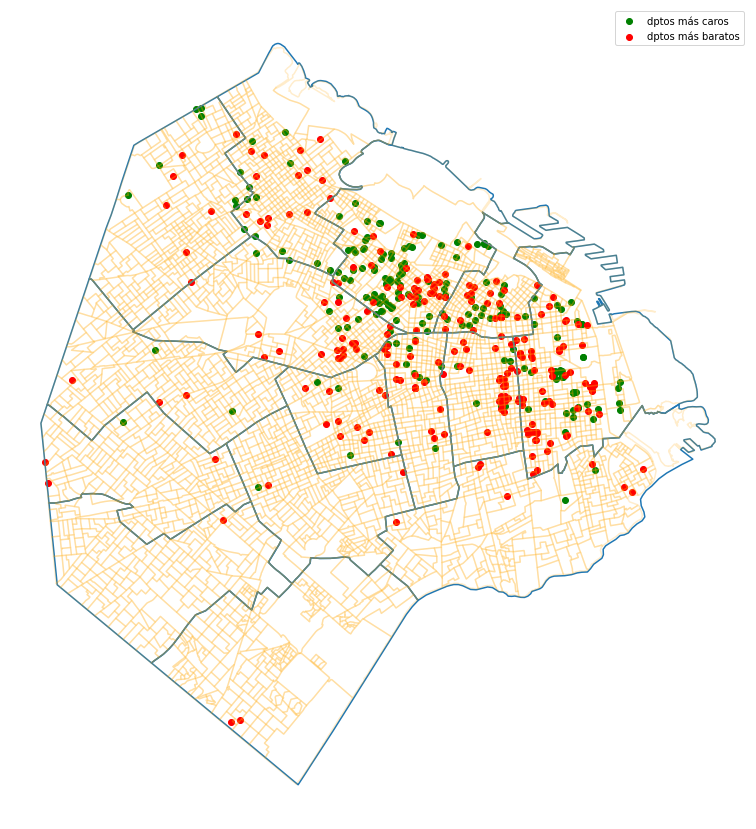

In [20]:

valores =  gdf.price.sort_values(ascending = True).iloc[-200:].values
filtro = gdf.price.apply(lambda x: x in valores)
caros = gdf[filtro]
valores =  gdf.price.sort_values(ascending = False).iloc[-200:].values
filtro = gdf.price.apply(lambda x: x in valores)
baratos = gdf[filtro]

base = caba.boundary.plot(figsize = (18,15))
radios.boundary.plot(ax = base, color = 'orange', alpha = 0.2)
#gdf[gdf.bedrooms >= 3].plot(ax = base, color = 'green')
caros.plot(ax = base, color = 'green', label = 'dptos más caros')
baratos.plot(ax = base, color = 'red', label = 'dptos más baratos')
base.set_axis_off()
plt.legend()

 ## **<font color="lightblue">Operaciones geométricas</font>**

<p align="justify">
Cuando trabajamos con múltiples conjuntos de datos espaciales, especialmente múltiples conjuntos de datos de polígonos o líneas, los usuarios a menudo desean crear nuevas formas basadas en lugares donde esos conjuntos de datos se superponen (o no se superponen). Estas manipulaciones a menudo se realizan utilizando el lenguaje de conjuntos: intersecciones, uniones y diferencias. Estos tipos de operaciones están disponibles en la biblioteca Geopandas a través del método <code>Overlay()</code>.
<br><br>
La idea básica se muestra en el gráfico a continuación. Para cada forma en el GeodataFrame izquierdo, esta operación se ejecuta contra cualquier otra forma en la derecha Geodataframe:

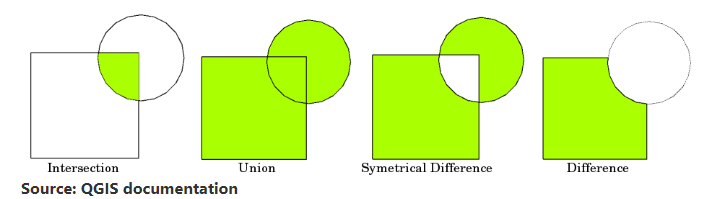

<p align="justify">
Estamos interesados en saber la información censal de los radios censales en dónde se encuentran los 10 departamentos más caros.

In [21]:
# Filtramos los 10 departamentos más caros
valores =  gdf.price.sort_values(ascending = True).iloc[-10:].values
filtro = gdf.price.apply(lambda x: x in valores)
caros = gdf[filtro]

# Realizamos una interesección  entre aquellos radios y los dptos
radios_caros = caros.overlay(radios, how = 'intersection', keep_geom_type = True)

# Le asignamos a radios caros la geometría del radio
geo = radios[radios.link.apply(lambda x: x in radios_caros.link.values)]['geometry']
radios_caros = radios_caros.set_geometry(geo.values)

<AxesSubplot:>

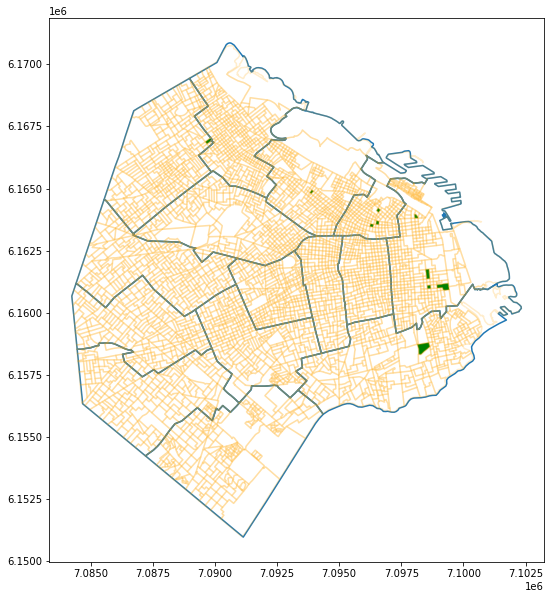

In [22]:
base = caba.boundary.plot(figsize = (12,10))
radios.boundary.plot(ax = base, color = 'orange', alpha = 0.2)
radios_caros.plot(ax = base, color = 'green')

In [23]:
radios_caros.groupby('link').agg({
    'price':'mean',
    'id': 'count',
    'ind01': 'first',
    'ind05': 'first',
    'ind06': 'first',
    'ind07': 'first',
    'nomdepto': 'first'
}).sort_values('price', ascending = False)

price  id ind01 ind05  ind06  ind07   nomdepto
link                                                             
020840100709  20500432.0   1   476   9.1   90.5   96.3  Comuna 12
020140101602   3000000.0   1   470   0.4   92.1    0.0   Comuna 2
020140100901   2918516.0   1   599   0.5   99.5   99.7   Comuna 2
020140101508   2678472.0   1   533   0.4   99.4   99.6   Comuna 2
020070102302   2532232.0   1   331   4.5   92.1   90.8   Comuna 1
020070102403   2484901.0   1   367   7.4   90.9   80.7   Comuna 1
020070100602   2300811.0   1   408   0.0  100.0  100.0   Comuna 1
020980101207   2070751.0   1   210   2.9   96.7   95.1  Comuna 14
020280101207   2070544.0   1   329  32.2   67.5   49.1   Comuna 4
020070101405   2050043.0   1   485   1.0   56.5   91.9   Comuna 1

<p align="justify">
Podemos construir buffers alrededor de puntos que nos permita contemplar un radio cercano a dicho punto. Esta es una forma de convertir un punto en un polígono, en estos caso círculos.
<br><br>
Vamos a considerar que en el radio de 200 metros de un departamento caro (barato) toda la zona es cara (barata).

c:\Anaconda3\envs\espacial\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Anaconda3\envs\espacial\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot:>

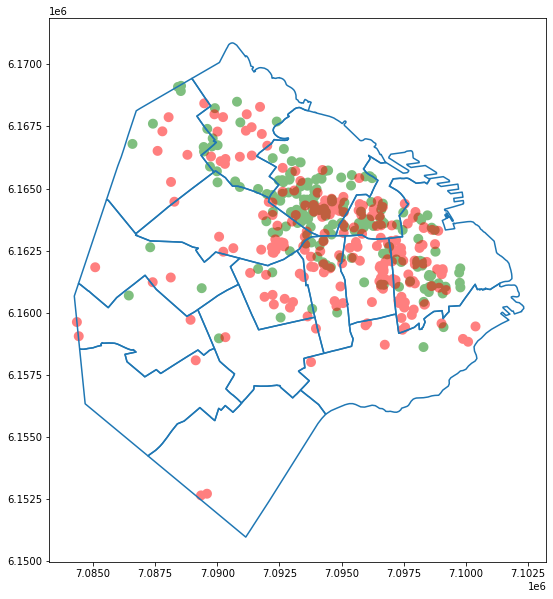

In [24]:
#filtramos los departamentos caros y baratos
valores =  gdf.price.sort_values(ascending = True).iloc[-200:].values
filtro = gdf.price.apply(lambda x: x in valores)
caros = gdf[filtro]
valores =  gdf.price.sort_values(ascending = False).iloc[-200:].values
filtro = gdf.price.apply(lambda x: x in valores)
baratos = gdf[filtro]

#generamos un buffer al rededor de ellos
caros['geometry'] = caros.buffer(200)
baratos['geometry'] = baratos.buffer(200)

# Unimos cada uno de los buffers anteriores en una sola figura
sup_cara = caros.unary_union
sup_barata = baratos.unary_union
sup_cara = gpd.GeoSeries(sup_cara)
sup_barata = gpd.GeoSeries(sup_barata)

# graficamos
base = caba.boundary.plot(figsize = (12,10))
sup_cara.plot(ax = base, color = 'green', alpha = 0.5)
sup_barata.plot(ax = base, color = 'red', alpha = 0.5)


<p align="justify">
Nuestra intención va ser determinar si las superficiens construidas con los $n$ departamentos más caros (baratos) también contiene a departamentos caros (baratos). Para eso vamos a ubicar a todos los departamentos dentro de cada una de las superficies.

In [25]:
inters_carobarato = caros.overlay(baratos, how = 'intersection')
solo_caros = caros.overlay(baratos, how = 'difference')
solo_baratos = baratos.overlay(caros, how = 'difference')

In [26]:
dptos_supcara = gdf.overlay(caros, how = 'intersection')
dptos_supbarata = gdf.overlay(baratos, how = 'intersection')
dptos_supinters = gdf.overlay(inters_carobarato, how = 'intersection')
dptos_supsolocara = gdf.overlay(solo_caros, how = 'intersection')
dptos_supsolobarata = gdf.overlay(solo_baratos, how = 'intersection')


In [27]:
l = [dptos_supcara, dptos_supbarata,dptos_supinters,dptos_supsolocara,dptos_supsolobarata]
nom = ["dptos_supcara", "dptos_supbarata","dptos_supinters","dptos_supsolocara","dptos_supsolobarata"]
dic = {}
i = 0
for df in l:
  df_dic = {}
  df_dic['prom'] = df.price_1.mean()
  df_dic['mediana'] = df.price_1.median()
  df_dic['cant'] = df.price_1.count()
  df_dic['std'] =df.price_1.std()
  dic[nom[i]] = df_dic
  i += 1
pd.DataFrame(dic).T

prom   mediana     cant           std
dptos_supcara         23081.849112   10176.0  18464.0  1.794404e+05
dptos_supbarata       16949.222914    8312.0  16226.0  1.136674e+05
dptos_supinters      692875.371039  166420.0  19820.0  1.033432e+06
dptos_supsolocara     23074.335897   10354.0   8973.0  2.307674e+05
dptos_supsolobarata    9527.228170    7869.0   6837.0  7.382528e+03

<p align="justify">
Se puede ver que la superficie en donde se juntan los $n$ más caros con los $n$ más baratos es la que promedia mayores precios, también tiene una mediana más alta y tiene la mayor cantidad de departamentos ahí.

 ### **<font color="lightblue">Unión de DataFrames espaciales</font>**

<p align="justify">
Si bien con <code>overlay()</code> podemos unir los dataframes no es precisamente la herramienta que ofrece geopandas para ello.
<br><br>
Para unir los GeoDataFrame tenemos dos opciones, la primera es conocer algun campo índice que nos permita distinguir de manera unívoca la fila y hacerlo de la misma forma como se hace con pandas.
<br><br>
La segunda opción, es unir los gdf de acuerdo a sus atributos espaciales, esta función se llama <code>sjoin()</code>.
<br><br>
Para utilizar dicha función debemos pasarle dos argumentos que son <code>how</code> y <code>predicate</code>.
<br><br>
El argumento how hace referencia a como se van a unir de acuerdo a los mismos criterios que en un dataframe común (left, join, right).
<br><br>
El argumento <code>predicate</code> es el que tiene que ver con los objetos espaciales y son los que usa la librería shapely:
<ul align="justify">
<li><b>intersects</b>: va unir las filas en caso tengan algunos puntos en común.
<li><b>contains</b>: los une si el de la izquierda contiene a los de la derecha.
<li><b>whithin</b>: al revés que contains, los une si el de la derecha esta contenido en el de la izquierda.
</ul><br>
<p align="justify">
La geometría que prevalece es la de la izquierda y puede quedar repetida

In [28]:
# Unimos los dataframe en caso de que el departamento esté contenido en el radio censal
radios_dptos = radios.sjoin( gdf, how = 'inner', predicate = 'contains')

# Filtramos el primer radio censal y notamos que contiene 5 departamentos en alquiler
radios_dptos[radios_dptos.link == radios.link.iloc[0]]

id                           nomloc       area  perimeter prov depto  \
0  21777  Ciudad Autónoma de Buenos Aires  18085.428    538.611   02   105   
0  21777  Ciudad Autónoma de Buenos Aires  18085.428    538.611   02   105   
0  21777  Ciudad Autónoma de Buenos Aires  18085.428    538.611   02   105   
0  21777  Ciudad Autónoma de Buenos Aires  18085.428    538.611   02   105   
0  21777  Ciudad Autónoma de Buenos Aires  18085.428    538.611   02   105   

  codloc frac radio          link  ... ind06 ind07  \
0    010   14    03  021050101403  ...  98.3  92.6   
0    010   14    03  021050101403  ...  98.3  92.6   
0    010   14    03  021050101403  ...  98.3  92.6   
0    010   14    03  021050101403  ...  98.3  92.6   
0    010   14    03  021050101403  ...  98.3  92.6   

                           nomprov   nomdepto  \
0  Ciudad Autónoma de Buenos Aires  Comuna 15   
0  Ciudad Autónoma de Buenos Aires  Comuna 15   
0  Ciudad Autónoma de Buenos Aires  Comuna 15   
0  Ciudad Autónoma de Buenos Aires  Comuna 15   
0  Ciudad Autónoma de Buenos Aires  Comuna 15   

                                            geometry index_right    price  \
0  POLYGON ((7092406.779 6163074.330, 7092311.998...       16499   5786.0   
0  POLYGON ((7092406.779 6163074.330, 7092311.998...       17185   5709.0   
0  POLYGON ((7092406.779 6163074.330, 7092311.998...        4764   4970.0   
0  POLYGON ((7092406.779 6163074.330, 7092311.998...       12143  11035.0   
0  POLYGON ((7092406.779 6163074.330, 7092311.998...       19905   6804.0   

   bedrooms  minimum_nights  maximum_nights  
0       1.0               4              28  
0       1.0              10            1125  
0       1.0              29             360  
0       1.0               3               8  
0       1.0               3              10  

[5 rows x 22 columns]

 ### **<font color="lightblue">Agregado de datos</font>**

<p align="justify">
Habitualmente uno necesita hacer análisis en valores agregados, en pandas se puede usar <code>groupby()</code> para agregar los valores. Pero en geopandas tenemos el problema que necesitamos agregar objetos espaciales y estos necesitan una función especial. Para esto usamos <code>dissolve()</code>
<br><br>
<code>dissolve</code> funciona de manera muy similar a <code>groupby</code>, la función va unir las geometrías de todos aquellas filas que cumplan el criterio que se pasa con el argumento <code>by</code>. Además, hay que definir cual es el criterio de agrupado de las demás columnas.
<br><br>
Para emprolijar un poco los valores eliminamos aquellos departamentos que tienen precios demasiados altos

<AxesSubplot:>

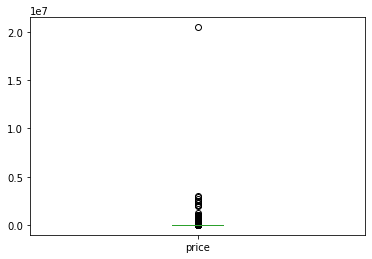

In [29]:
radios_dptos.price.plot(kind = 'box')

In [30]:
radios_dptos = radios_dptos[radios_dptos.price < 20000]

# Generamos un nuevo gdf que
caba_radios = radios_dptos.dissolve(by = 'link', aggfunc = { 'area': 'first',
                                                            'perimeter': 'first',
                                                            'depto': 'first',
                                                            'price': 'mean',
                                                            'bedrooms': 'mean'
                                                            })
caba_radios

geometry         area  \
link                                                                           
020070100101  POLYGON ((7099612.059 6163296.147, 7099566.622...  1768511.573   
020070100223  POLYGON ((7097806.205 6165101.091, 7097788.976...    15150.899   
020070100401  POLYGON ((7097764.531 6164310.073, 7097705.952...    21601.034   
020070100402  POLYGON ((7097764.531 6164310.073, 7097846.460...    31779.823   
020070100403  POLYGON ((7097654.438 6164005.894, 7097705.952...    40554.432   
...                                                         ...          ...   
021050102109  POLYGON ((7093285.115 6162860.228, 7093381.116...    19821.657   
021050102110  POLYGON ((7093476.648 6163022.678, 7093557.078...    16303.070   
021050102111  POLYGON ((7093668.870 6163013.561, 7093667.383...    17640.239   
021050102112  POLYGON ((7093570.738 6163102.549, 7093672.971...    20417.674   
021050102113  POLYGON ((7093943.368 6163072.069, 7093819.457...    38594.977   

              perimeter depto         price  bedrooms  
link                                                   
020070100101  14257.869   007  11520.285714  1.000000  
020070100223    717.420   007   7248.000000  1.000000  
020070100401    594.238   007   8264.243243  1.333333  
020070100402    732.380   007  11057.000000  1.545455  
020070100403    844.763   007  10424.000000  1.375000  
...                 ...   ...           ...       ...  
021050102109    577.928   105   7482.000000  1.285714  
021050102110    511.587   105   9801.111111  1.142857  
021050102111    526.566   105   7543.750000  1.000000  
021050102112    625.116   105  10858.750000  1.250000  
021050102113    944.575   105   8405.181818  1.095238  

[2464 rows x 6 columns]

<AxesSubplot:>

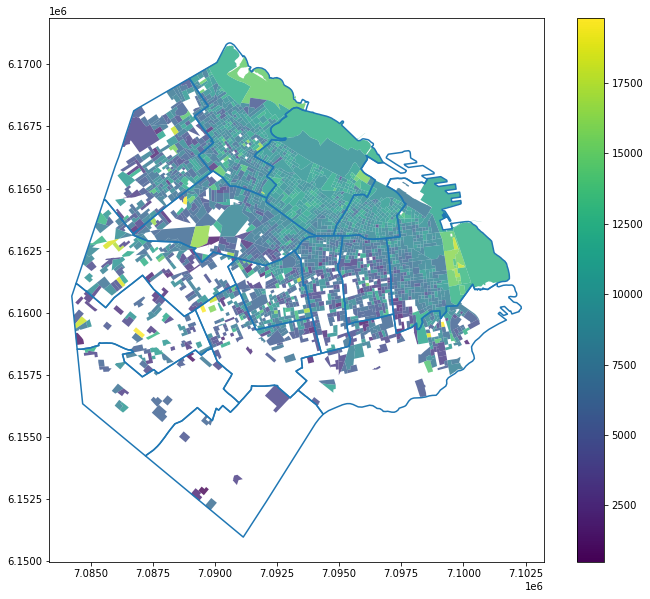

In [31]:
base = caba.boundary.plot(figsize = (12,10))
caba_radios.plot('price', ax = base, legend = True, alpha = 0.8)

<p align="justify">
Los valores en blanco que encontramos se debe a que esos radios censales no tienen ningún departamento en su interior y elegimos el criterio  <code>how = 'inner'</code>. Si queremos tener todos los radios, debemos usar el criterio <code>how = 'left'</code>.

<AxesSubplot:>

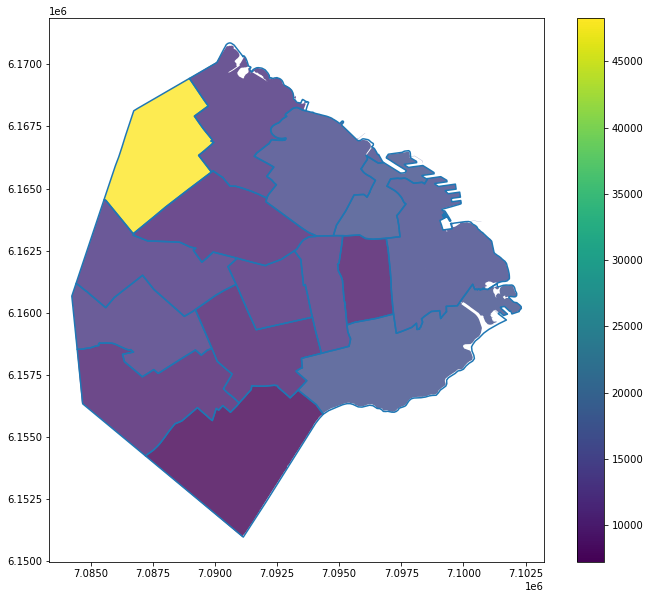

In [32]:
# Unimos los gdf
radios_dptos = radios.sjoin( gdf, how = 'left', predicate = 'contains')

# Completamos con 0 aquellos radios que no tienen ningún alquiler
caba_radios['price'] = caba_radios.price.fillna(0)

# Agregamos a nivel comuna los valores
dptos_price = radios_dptos.dissolve('depto', aggfunc= 'mean')

# Elaboramos el mapa
base = caba.boundary.plot(figsize = (12,10))
dptos_price.plot('price', ax = base, legend = True, alpha = 0.8)

 # **<font color="lightblue">Conclusiones</font>**

<p align="justify">
En este notebook nosotros:<br><br>
✅ Transformamos un csv con coordenadas en un GeoDataFrame <br>
✅ Mezlcamos la información de diferentes dataframe. <br>
✅ Operamos con figuras geométricas para extraer nueva información. <br>
✅ Agregamos los datos en niveles . <br>

<p align="justify">

